# Data

> All things Data (Processing, exploration, Visualization, augmentation, loading, etc)

In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore.utils import *
from fastcore import *

In [ ]:
#| export
import os
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [ ]:
#| export
cl_labels = ["DR", "Glaucoma", "AMD"]

In [ ]:
#| export
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels


### Utils

In [ ]:
#| export
import importlib
def get_cls(module_name, class_name):
    module = importlib.import_module(module_name)
    return getattr(module, class_name)

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
def old_show_batch(dl, denormalize_tf, save_to= "./batch.png", aug= False):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.savefig(save_to)
        plt.show()

    dataiter = iter(dl)
    images, labels = next(dataiter)
    if aug and images.dim() == 5:
        images = images.flatten(0, 1)
        labels = labels.flatten(0, 1)
        
    images = denormalize_tf(images)
    images = torch.clamp(images, 0, 1)
        
    indices = [torch.where(row == 1)[0].tolist() for row in labels]
    print('Labels: ',[[cl_labels[i] for i in idx] for idx in indices])
    imshow(torchvision.utils.make_grid(images))

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
def show_batch(dl, denormalize_tf, save_to="./batch.png", aug=False):
    dataiter = iter(dl)
    images, labels = next(dataiter)

    if aug and images.ndim == 5:
        images = images.flatten(0, 1)
        labels = labels.flatten(0, 1)
        
    images = denormalize_tf(images)
    print(f"Max pixel value: {images.max().item()}")
    print(f"Mean pixel value: {images.mean().item()}")
    images = torch.clamp(images, 0, 1)

    grid_img = torchvision.utils.make_grid(images, nrow=8) # nrow controls how many images per row
    np_grid = grid_img.permute(1, 2, 0).cpu().numpy()

    indices = [torch.where(row == 1)[0].tolist() for row in labels]
    batch_label_names = [[cl_labels[i] for i in idx] for idx in indices]
    print('Labels in this batch:', batch_label_names)

    plt.figure(figsize=(15, 10))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.savefig(save_to, bbox_inches='tight')
    plt.show()

### Transforms

#### Base Transforms

In [ ]:
#| export
image_size = 256
base_tf = transform = v2.Compose([
        v2.Resize((image_size, image_size)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

denormalize_tf = v2.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
#| hide
ds = RetinaMultiLabelDataset(csv_file='../data/train.csv', 
                             image_dir='../data/images/train', 
                             transform=base_tf)

In [ ]:
#| hide
sample = ds[0]
img, labels = sample

In [ ]:
#| hide
img.shape, labels

(torch.Size([3, 256, 256]), tensor([1., 0., 0.]))

In [ ]:
#| hide
img.min(), img.max()

(tensor(-2.1179), tensor(2.0605))

Labels:  [['DR'], ['AMD'], ['AMD'], ['DR']]


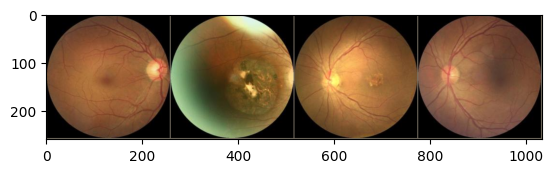

In [ ]:
#| hide
import matplotlib.pyplot as plt
import numpy as np
import torchvision


trainloader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=2)
show_batch(trainloader,denormalize_tf)


#### Augmenration transforms


In [ ]:
#| export
class RetinaMultiLabelDatasetAug(Dataset):
    def __init__(self, ds, transform=None, V=2):
        self.ds = ds
        self.V = V
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item[0]
        return torch.stack([self.transform(img) for _ in range(self.V)]), item[1]



In [ ]:
#| export
image_size = 256
aug_train_tf = v2.Compose([
    # 1. Geometric & Color Augs (on PIL or Int Tensor)
    v2.RandomResizedCrop(256, scale=(0.5, 1.0)),
    v2.RandomHorizontalFlip(),
    v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8), # Dialed down from 0.8
    
    # 2. Convert to Float Tensor (Range 0.0 to 1.0)
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    
    # 3. Float-based Augs (Range must be 0-1)
    v2.RandomApply([v2.GaussianBlur(kernel_size=25)], p=0.5),
    v2.RandomApply([v2.RandomSolarize(threshold=0.8)], p=0.2), # Higher threshold = less dark
    
    # 4. NORMALIZATION ALWAYS LAST
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_test_tf = v2.Compose(
            [
                v2.Resize(image_size),
                v2.CenterCrop(image_size),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
)

In [ ]:
#| hide
ds = RetinaMultiLabelDataset(csv_file='../data/train.csv',
                            image_dir='../data/images/train',
                            transform=aug_train_tf)

In [ ]:
#| hide
sample = ds[0]
img, labels = sample
img.shape, labels

(torch.Size([3, 256, 256]), tensor([1., 0., 0.]))

In [ ]:
#| hide
aug_ds = RetinaMultiLabelDatasetAug(ds, transform=aug_train_tf, V=2)
sample = aug_ds[0]
imgs, labels = sample
imgs.shape, labels

(torch.Size([2, 3, 256, 256]), tensor([1., 0., 0.]))

Max pixel value: 1.5702214241027832
Mean pixel value: 0.15389631688594818
Labels in this batch: [[], [], ['DR'], ['DR'], [], [], [], [], ['DR'], ['DR'], [], []]


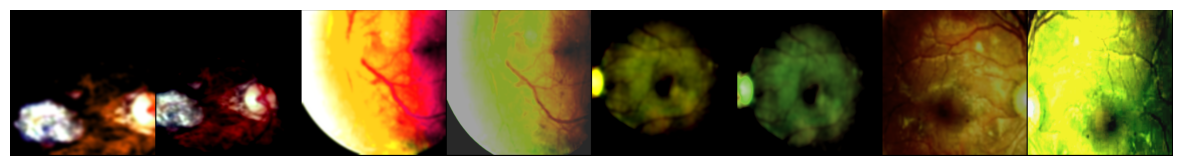

In [ ]:
#| hide
dl = DataLoader(aug_ds, batch_size=4, shuffle=True, num_workers=2)
show_batch(dl, denormalize_tf, aug= True)

### Data Loaders

In [ ]:
#| export
def init_data(cfg, transform=base_tf, num_workers=0):

    train_csv = os.path.join(cfg.data.data_root , "train.csv")
    train_image_dir = os.path.join(cfg.data.data_root , "images", "train")

    val_csv = os.path.join(cfg.data.data_root , "val.csv")
    val_image_dir =  os.path.join(cfg.data.data_root , "images", "val")
    
    test_csv = os.path.join(cfg.data.data_root , "offsite_test.csv")
    test_image_dir = os.path.join(cfg.data.data_root , "images", "offsite_test")

    ds_cls = get_cls("dl.data", "RetinaMultiLabelDataset")

    train_ds = ds_cls(train_csv, train_image_dir, transform)
    val_ds   = ds_cls(val_csv, val_image_dir, transform)
    test_ds  = ds_cls(test_csv, test_image_dir, transform)

    if cfg.data.name == "RetinaMultiLabelDatasetAug":    
        ds_cls = get_cls("dl.data", cfg.data.name)
        train_ds = ds_cls(train_ds, transform=transform, V=cfg.data.V)
        val_ds = ds_cls(val_ds, transform=transform, V=1)
        test_ds = ds_cls(test_ds, transform=transform, V=1)
        

    train_loader = DataLoader(train_ds, batch_size=cfg.data.batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_ds, batch_size=cfg.data.batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_ds, batch_size=cfg.data.batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader

In [ ]:
#| hide
from omegaconf import OmegaConf
cfg = OmegaConf.load("../cfgs/task_1/resnet/eval.yaml")
cfg.data.batch_size = 5
cfg.data.data_root = "../data"
train_loader, val_loader, test_loader = init_data(
    cfg,
    transform=base_tf,
    num_workers=2
)

Max pixel value: 2.4285714626312256
Mean pixel value: -0.7700015902519226
Labels in this batch: [['DR'], [], [], [], ['DR'], [], ['DR'], [], [], ['DR'], [], [], [], [], ['DR']]


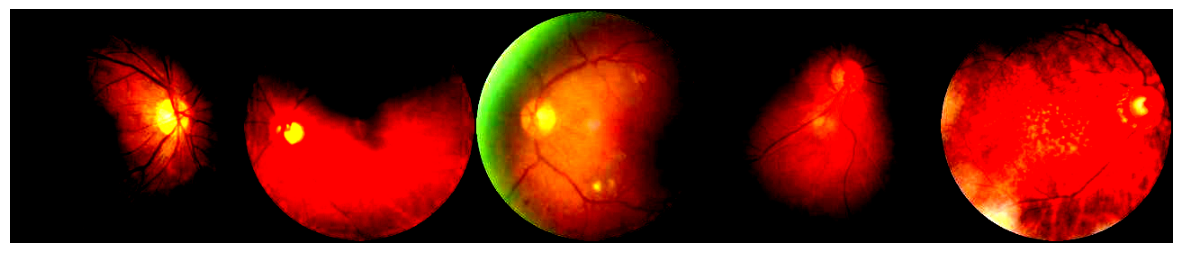

In [ ]:
#| hide
show_batch(train_loader, denormalize_tf)

In [ ]:
#| hide
from omegaconf import OmegaConf
cfg = OmegaConf.load("../cfgs/task_1/resnet/eval.yaml")
cfg.data.batch_size = 5
cfg.data.data_root = "../data"
cfg.data.name = "RetinaMultiLabelDatasetAug"
train_loader, val_loader, test_loader = init_data(
    cfg,
    transform=base_tf,
    num_workers=2
)

Max pixel value: 2.4285714626312256
Mean pixel value: -0.5090987086296082
Labels in this batch: [[], ['DR'], [], ['DR'], [], [], ['DR'], [], [], ['DR'], [], [], ['DR'], [], []]


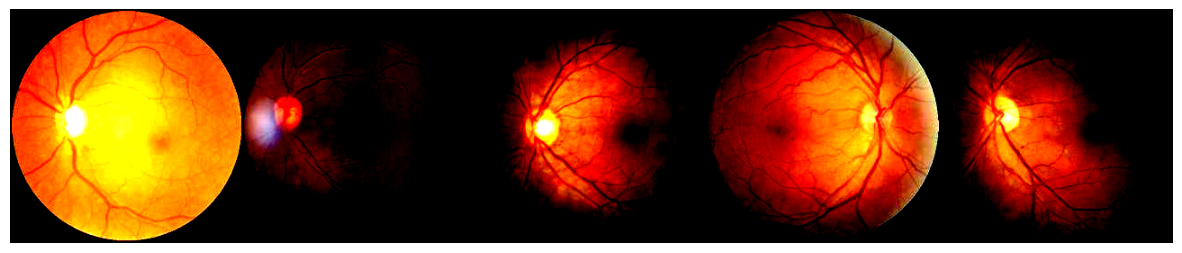

In [ ]:
#| hide
show_batch(train_loader, denormalize_tf, aug=True)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()